# Group 2 Phase 3 - Cats vs Dogs Detector (CaDoD) 
"FrankenNet" convolutional neural network


## Team Members

* Ben Perkins
* Lauren Madar
* Mangesh Walimbe
* Samin Barghan

![](./other/team.png)

## Project Abstract

One of the fundamental tasks in classifying images is object detection within images. Algorithms often employ a ‘bounding box’ tool. To study bounding boxes, our team first evaluated 3 models with GridSearchCV, to be trained on existing bounding box data for the purpose of predicting bounding boxes.  The best model was used for bounding box prediction.

After exploring linear and logistic regression models with SciKit Learn, we created several PyTorch models with classification and bounding box predictions using Cross Entropy and Mean Squared Error loss functions. PyTorch allows for a much simpler modeling, training and prediction process.

## Project Description

The purpose of this project is create an end to end process in machine learning to create an object classifier and bounding box predictor for cat and dog images. There are about 13,000 images of varying shapes and aspect ratios. They are all RGB images and have bounding box coordinates stored in a .csv file. In order to create a detector, we will first have to preprocess the images to be all of the same shapes, and flatten them from a 3D array to 2D. Then we will feed this array into a linear localization predictor and a logistic regression model to predict labels and bounding boxes.


## Data Description 

The image archive `cadod.tar.gz` is a subset [Open Images V6](https://storage.googleapis.com/openimages/web/download.html). It contains a total of 12,966 images of dogs and cats.


Image bounding boxes are stored in the csv file `cadod.csv`. The following describes whats contained inside the csv.

* ImageID: the image this box lives in.
* Source: indicates how the box was made:
    * xclick are manually drawn boxes using the method presented in [1], were the annotators click on the four extreme points of the object. In V6 we release the actual 4 extreme points for all xclick boxes in train (13M), see below.
    * activemil are boxes produced using an enhanced version of the method [2]. These are human verified to be accurate at IoU>0.7.
* LabelName: the MID of the object class this box belongs to.
* Confidence: a dummy value, always 1.
* XMin, XMax, YMin, YMax: coordinates of the box, in normalized image coordinates. XMin is in [0,1], where 0 is the leftmost pixel, and 1 is the rightmost pixel in the image. Y coordinates go from the top pixel (0) to the bottom pixel (1).
* XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y: normalized image coordinates (as XMin, etc.) of the four extreme points of the object that produced the box using [1] in the case of xclick boxes. Dummy values of -1 in the case of activemil boxes.

The attributes have the following definitions:

* IsOccluded: Indicates that the object is occluded by another object in the image.
* IsTruncated: Indicates that the object extends beyond the boundary of the image.
* IsGroupOf: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
* IsDepiction: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
* IsInside: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).
For each of them, value 1 indicates present, 0 not present, and -1 unknown.

Identifying columns: ImageID, Source, LabelName, Confidence

Dimensional and positional columns: XMin, XMax, YMin,YMax, XClick1X, XClick2X, XClick3X, XClick4X, XClick1Y, XClick2Y, XClick3Y, XClick4Y

Bounding box and image descriptive columns: IsOccluded, IsTruncated, IsGroupOf, IsDepiction, IsInside

When we look at a few random images, we can see that the photos vary in color and have different shapes and sizes. Also, we can see a photo with both a cat and dog, with the cat being barely visible (bottom row middle) so this shows any classifier fit on this type of photos will have to be robust.

![Sample Images](https://iu.instructure.com/users/6469957/files/119176770/preview?verifier=vwgzljiRpIRlNhVQK4aPqNwqrlygkVDkhnAhSrNf)

The first step to prepare data must be to standardize the images. Photos will have to be reshaped before modeling so that all images have the same shape and size. One approach we may use would be to load all photos and look at the distribution of the photo widths and heights then determine a new image size that fits the majority of the images. Smaller size allows a model to train more quickly. Another approach would be to start with a fixed size of 200x200 pixels. We can also filter color images to determine where the majority or highest density of each color pixel lies within the image.

The metadata contained in the csv file will need to be matched to each image file, and during Exploratory Data Analysis, we will determine relationships between any of the columns using pandas. For example, how many images contain more than one cat or dog (IsGroupOf)? How many of those images have IsOccluded, IsTruncated, IsInside? Can we determine if the bounding box of one object is larger than the other in order to guess the ‘main’ object? This will drive creation of additional features.

The code and project files are stored in a GitHub repository: i526Sp21Group2 (SEE PDF). We will impute missing data and document the strategy used, if needed (depending on the results of EDA). NumPy DataFrames embedded in our project Jupyter Notebook will track our exploration and transformation of data and engineering of any features ahead of training and fitting. Other Python libraries may be used for visualizations and will be documented.

In [1]:
# Import general modules
import os
import glob
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tarfile
from tqdm.notebook import tqdm
from PIL import Image
import warnings

from collections import Counter
import seaborn as sns

# PyTorch Modules
import torch
import torch.nn
import torch.nn.functional as F
from torch.nn import ReLU
from torch import nn, optim
from torch.optim import Adam
from torch.autograd import Variable
import torch.utils 
from torch.utils.data import Dataset as torchDataset
from torch.utils.data import DataLoader as torchDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, transforms, utils
from torchvision.io import read_image

In [2]:
def extract_tar(file, path):
    """
    function to extract tar.gz files to specified location
    
    Args:
        file (str): path where the file is located
        path (str): path where you want to extract
    """
    with tarfile.open(file) as tar:
        files_extracted = 0
        for member in tqdm(tar.getmembers()):
            if os.path.isfile(path + member.name[1:]):
                continue
            else:
                tar.extract(member, path)
                files_extracted += 1
        tar.close()
        if files_extracted < 3:
            print('Files already exist')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Import Data

### Unarchive data

Place the cadod.tar.gz into the same folder as this notebook. We've already extracted the files into the ./data folder (to prevent committing the large gz file to github).

In [4]:
useLocalInJupyter = True # set to False if using Colab, set to True if using locally

# UPDATE PATHS BELOW depending on your GDrive or local setup.

if useLocalInJupyter == False:
    path = '/content/drive/MyDrive/FinalProject/data/cadod/'
    extract_tar('/content/drive/MyDrive/FinalProject/data/cadod.tar.gz', path)
 
if useLocalInJupyter == True:
    path = './data/cadod/'
    extract_tar('./data/cadod.tar.gz', path)

  0%|          | 0/25936 [00:00<?, ?it/s]

In [5]:
df = pd.read_csv(path + '../cadod.csv')

In [6]:
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000b9fcba019d36,xclick,/m/0bt9lr,1,0.165000,0.903750,0.268333,0.998333,1,1,...,0,0,0.636250,0.903750,0.748750,0.165000,0.268333,0.506667,0.998333,0.661667
1,0000cb13febe0138,xclick,/m/0bt9lr,1,0.000000,0.651875,0.000000,0.999062,1,1,...,0,0,0.312500,0.000000,0.317500,0.651875,0.000000,0.410882,0.999062,0.999062
2,0005a9520eb22c19,xclick,/m/0bt9lr,1,0.094167,0.611667,0.055626,0.998736,1,1,...,0,0,0.487500,0.611667,0.243333,0.094167,0.055626,0.226296,0.998736,0.305942
3,0006303f02219b07,xclick,/m/0bt9lr,1,0.000000,0.999219,0.000000,0.998824,1,1,...,0,0,0.508594,0.999219,0.000000,0.478906,0.000000,0.375294,0.720000,0.998824
4,00064d23bf997652,xclick,/m/0bt9lr,1,0.240938,0.906183,0.000000,0.694286,0,0,...,0,0,0.678038,0.906183,0.240938,0.522388,0.000000,0.370000,0.424286,0.694286


In [7]:
df.LabelName.unique()

array(['/m/0bt9lr', '/m/01yrx'], dtype=object)

# Exploratory Data Analysis

## Statistics

In [8]:
print(f"There are a total of {len(glob.glob1(path, '*.jpg'))} images")
print(f"The total size is {os.path.getsize(path)/1000} MB")
df.shape

There are a total of 12966 images
The total size is 830.016 MB


(12966, 21)

Replace `LabelName` with human readable labels

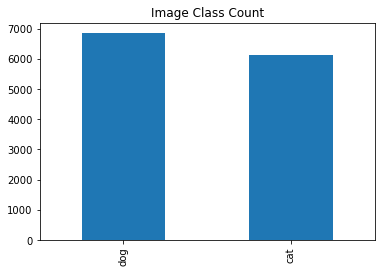

In [9]:
df.LabelName.replace({'/m/01yrx':'cat', '/m/0bt9lr':'dog'}, inplace=True)
df.LabelName.value_counts()
df.LabelName.value_counts().plot(kind='bar')
plt.title('Image Class Count')
plt.show()

In [10]:
df.describe()

,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
count,12966.0,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000,12966.000000
mean,1.0,0.099437,0.901750,0.088877,0.945022,0.464754,0.738470,0.013651,0.045427,0.001157,0.390356,0.424582,0.494143,0.506689,0.275434,0.447448,0.641749,0.582910
std,0.0,0.113023,0.111468,0.097345,0.081500,0.499239,0.440011,0.118019,0.209354,0.040229,0.358313,0.441751,0.405033,0.462281,0.415511,0.401580,0.448054,0.403454
min,1.0,0.000000,0.408125,0.000000,0.451389,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.0,0.000000,0.830625,0.000000,0.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221293,0.096875,0.285071,0.130000,0.024323,0.218333,0.405816,0.400000
50%,1.0,0.061250,0.941682,0.059695,0.996875,0.000000,1.000000,0.000000,0.000000,0.000000,0.435625,0.415625,0.531919,0.623437,0.146319,0.480838,0.825000,0.646667
75%,1.0,0.167500,0.998889,0.144853,0.999062,1.000000,1.000000,0.000000,0.000000,0.000000,0.609995,0.820000,0.787500,0.917529,0.561323,0.729069,0.998042,0.882500
max,1.0,0.592500,1.000000,0.587088,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999375,0.999375,1.000000,0.999375,0.999375,0.999375,1.000000,0.999375


## Sample of Images

By plotting random samples of the images along with the bounding boxes and XClick points, we see that every image has a bounding box but not every image has valid (positive) XClick information. From the descriptions on the CaDoD site, the bounding boxes were either derived from the extreme points clicked (aka XClick) by a human, or provided in some other way (prediction or manually drawn as a box). 

Further, it seems that the XClick items follow no system. For example, they are not in a predictable clockwise or counterclockwise ordering, they do not seem to start on a particular edge (like left side vs right side).

Since the bounding box information is more widely available and, where XClick is present, bounding box is derived from XClick, we can drop the XClick feature later on and just focus more on examining the bounding box attributes.

In [16]:
def RandomSixImages(items, orig=True, optSize=""):
    # orig = True means original size.  If False, specify 128 or 32 for resized images.
    fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(15,10))
    ax = ax.flatten() 
    
    impath = path
    
    if (orig == False):
        impath = path + "../../images/resized"+str(optSize) +"/"

    for i,j in enumerate(np.random.choice(items.shape[0], size=6, replace=False)):
        img = mpimg.imread(impath + items.ImageID.values[j] + '.jpg')
        h, w = img.shape[:2]
        coords = items.iloc[j,4:8]
        xclick_xcoords = items.iloc[j,13:17]*w
        xclick_ycoords = items.iloc[j,17:21]*h
    
        centerimg = [w/2, h/2]
        centerbox = [(coords[1]*w-coords[0]*w)/2 + coords[0]*w, (coords[3]*h-coords[2]*h)/2 + coords[2]*h]
    
        ax[i].imshow(img)
        ax[i].set_title(items.LabelName.values[j])
    
        # Plot the bounding box as a red border
        ax[i].add_patch(plt.Rectangle((coords[0]*w, coords[2]*h), 
                                  coords[1]*w-coords[0]*w, coords[3]*h-coords[2]*h, 
                                  edgecolor='red', facecolor='none'))
    
        ax[i].plot([centerimg[0], centerbox[0]],[centerimg[1], centerbox[1]],linestyle='dotted',linewidth=3,color='red')
        ax[i].plot(centerimg[0], centerimg[1],'bo', markersize=10)
        ax[i].plot(centerimg[0], centerimg[1],'w.')
        ax[i].plot(centerbox[0], centerbox[1],'ro', markersize=10)
        ax[i].plot(centerbox[0], centerbox[1],'w.')
    
        # If this image has valid positive XClick coords, plot those points
        if xclick_xcoords.any() < 0 or xclick_ycoords.any() < 0 :
            print("cannot plot, invalid (negative) xclick!")
        else :
            # plot each XClick point in scale on the image, 1 = blue, 2 = green, 3 = yellow, 4 = red
            ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'w.', markersize=20, label="1")
            ax[i].plot(xclick_xcoords[0], xclick_ycoords[0],'b+', markersize=8)
            ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'w.', markersize=20, label="2")
            ax[i].plot(xclick_xcoords[1], xclick_ycoords[1],'g+', markersize=8)
            ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'w.', markersize=20, label="3")
            ax[i].plot(xclick_xcoords[2], xclick_ycoords[2],'y+', markersize=8)
            ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'w.', markersize=20, label="4")
            ax[i].plot(xclick_xcoords[3], xclick_ycoords[3],'r+', markersize=8)       
    plt.tight_layout()
    plt.show()


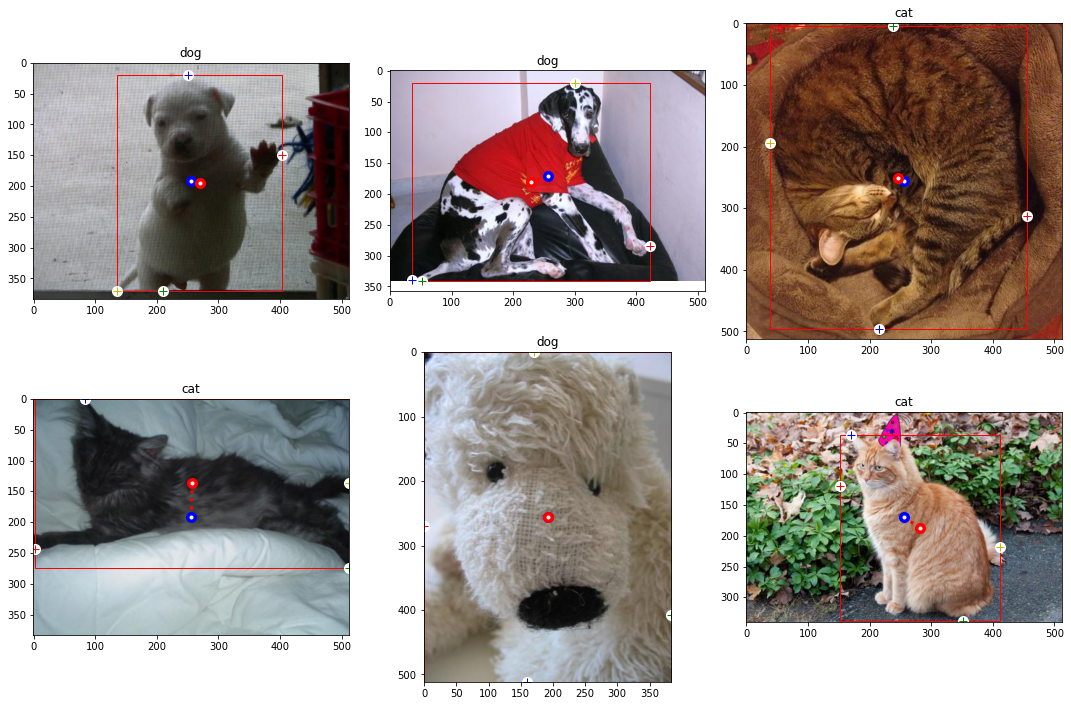

In [17]:
# plot random 6 images (original size)
RandomSixImages(df)

Let's look at the IsDepiction column.  This seems to indicate if the image is a depiction (drawing, painting, not a 'real' animal photo).

In [18]:
depictioncount = Counter(df.IsDepiction)
depictioncount

Counter({0: 12371, 1: 592, -1: 3})

There are 3 items with -1 values. Let's look at those images to see what they're like.

In [19]:
df[df.IsDepiction < 0]

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
6878,004b6bf1ef1414b6,activemil,cat,1,0.002500,0.919375,0.002506,0.950710,-1,-1,...,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7084,021fd3fec9e6a438,activemil,cat,1,0.107500,0.957500,0.165625,0.884375,-1,-1,...,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7170,03c7118d468d94aa,activemil,cat,1,0.075548,0.874898,0.219601,0.900181,-1,-1,...,-1,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Let's look at the 3 images with IsDepiction = -1

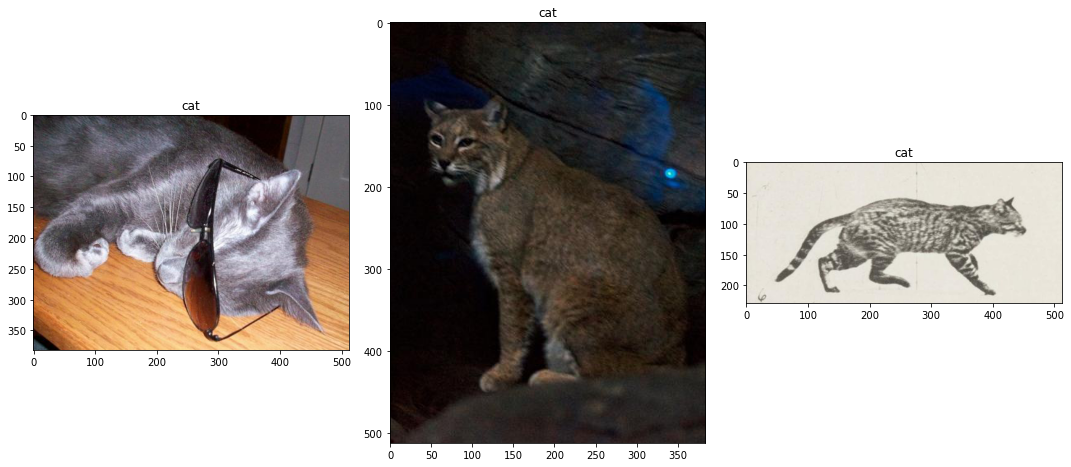

In [20]:
# plot 3 "IsDepiction" = -1 images.
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False,figsize=(15,10))
ax = ax.flatten()
depictionimgs = df[df.IsDepiction < 0].to_numpy()
iterax = 0
for item in depictionimgs:
    img = mpimg.imread(path + item[0] + '.jpg')
    ax[iterax].imshow(img)
    ax[iterax].set_title(item[2])
    iterax += 1
plt.tight_layout()
plt.show()

Well, it looks from the dataframe above that these 3 images from Source = "activemil" don't have any XClick info or other info, though they do have bounding boxes.  These are NOT depictions/drawings though, so we can look for -1 values to clean up in our Feature Engineering stage.

What else can we tell from this?  Let's see if there is any other -1 data to deal with.

In [21]:
occludecount = Counter(df.IsOccluded)
truncatecount = Counter(df.IsTruncated)
groupcount = Counter(df.IsGroupOf)
insidecount = Counter(df.IsInside)
print (occludecount, truncatecount, groupcount, insidecount)

Counter({0: 6934, 1: 6029, -1: 3}) Counter({1: 9578, 0: 3385, -1: 3}) Counter({0: 12783, 1: 180, -1: 3}) Counter({0: 12945, 1: 18, -1: 3})


Gladly, this tells us that the same 3 images have -1 data, but others are ok (using either 0 or 1 for the IsOccluded, IsTruncated, IsGroupOf or IsInside columns.

## Image shapes and sizes

Go through all images and record the shape of the image in pixels and the memory size

In [22]:
img_shape = []
img_size = np.zeros((df.shape[0], 1))
img_format = []
for i,f in enumerate(tqdm(glob.glob1(path, '*.jpg'))):
    file = path+'/'+f
    img = Image.open(file)
    img_shape.append(f"{img.size[0]}x{img.size[1]}")
    imgratio = img.size[0]/img.size[1]
    if imgratio > 1 :
        img_format.append('landscape')
    elif imgratio < 1:
        img_format.append('portrait')
    else:
        img_format.append('square')
    img_size[i] += os.path.getsize(file)
    img.close() # cleanup!

  0%|          | 0/12966 [00:00<?, ?it/s]

Count all the different image shapes

In [23]:

img_shape_count = Counter(img_shape)
img_format_count = Counter(img_format)
img_format_count

Counter({'landscape': 9657, 'square': 1216, 'portrait': 2093})

In [24]:
# create a dataframe for image shapes
img_df = pd.DataFrame(set(img_shape_count.items()), columns=['img_shape','img_count'])
img_df.shape

(594, 2)

In [25]:
# create a dataframe for simple image aspect ratios
img_ratio_df = pd.DataFrame(set(img_format_count.items()), columns=['aspect_ratio','img_count'])
img_ratio_df.head()

,aspect_ratio,img_count
0,landscape,9657
1,portrait,2093
2,square,1216


There are a ton of different image shapes. Let's narrow this down by getting a sum of any image shape that has a count less than 100 and put that in a category called `other`

In [26]:
img_df = img_df.append({'img_shape': 'other','img_count': img_df[img_df.img_count < 100].img_count.sum()}, 
                       ignore_index=True)

Drop all image shapes

In [27]:
img_df = img_df[img_df.img_count >= 100]

Check if the count sum matches the number of images

In [28]:
img_df.img_count.sum() == df.shape[0]

True

## Depiction Images

Now, let's look at a random sample of images marked as "Depictions" (IsDepiction = 1). This would indicate a drawing or other nonstandard image representation of a dog or cat and we need to verify this assumption.

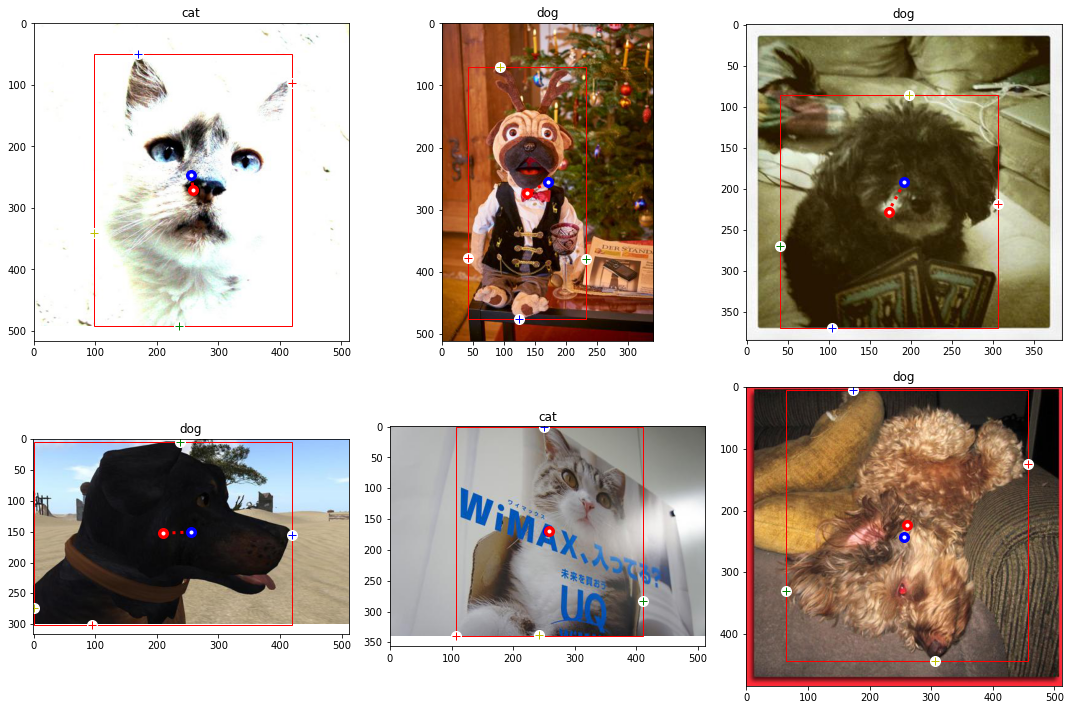

In [29]:
# plot random 6 depiction images (original size)
RandomSixImages(df[df.IsDepiction > 0])

Well, it doesn't seem like IsDepiction tells us a whole lot.  Sometimes, IsDepiction is set to 1 for paintings, statues, or just 'heavily filtered' or artistically distorted photos, but also photos that have low light or are black and white are tagged with this feature.

## Plot aspect ratio

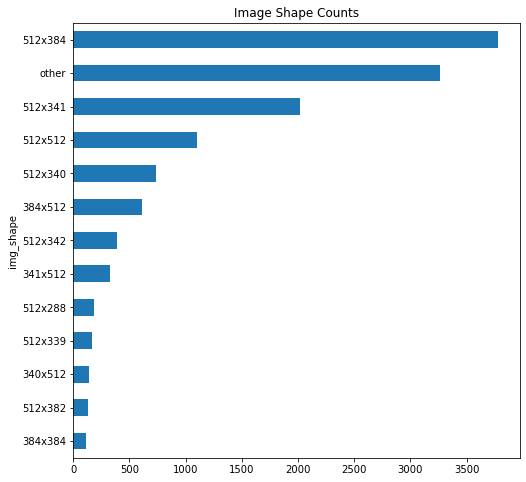

In [30]:
img_df.sort_values('img_count', inplace=True)
img_df.plot(x='img_shape', y='img_count', kind='barh', figsize=(8,8), legend=False)
plt.title('Image Shape Counts')
plt.show()

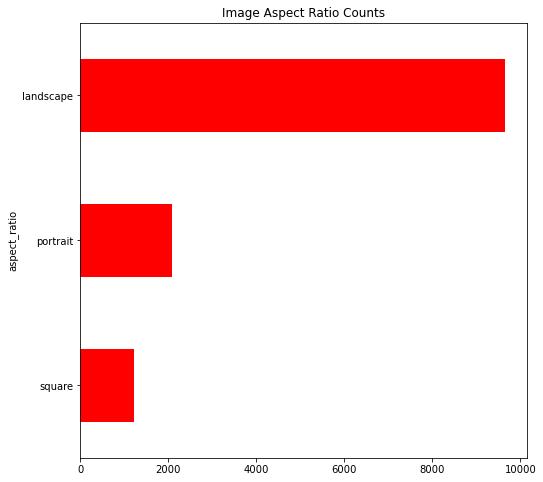

In [31]:
img_ratio_df.sort_values('img_count', inplace=True)
img_ratio_df.plot(x='aspect_ratio', y='img_count', kind='barh', color='red', figsize=(8,8), legend=False)
plt.title('Image Aspect Ratio Counts')
plt.show()

In [32]:
np.min(img_size), np.max(img_size)

# convert to megabytes
img_size = img_size / 1000
np.min(img_size), np.max(img_size)

(4.471, 502.8)

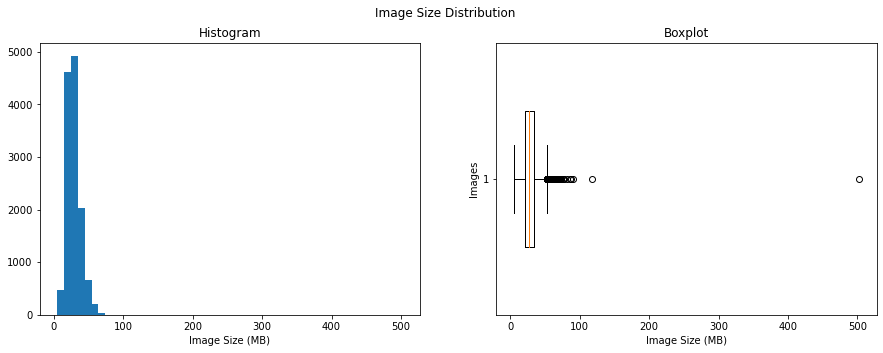

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Image Size Distribution')
ax[0].hist(img_size, bins=50)
ax[0].set_title('Histogram')
ax[0].set_xlabel('Image Size (MB)')
ax[1].boxplot(img_size, vert=False, widths=0.5)
ax[1].set_title('Boxplot')
ax[1].set_xlabel('Image Size (MB)')
ax[1].set_ylabel('Images')
plt.show()

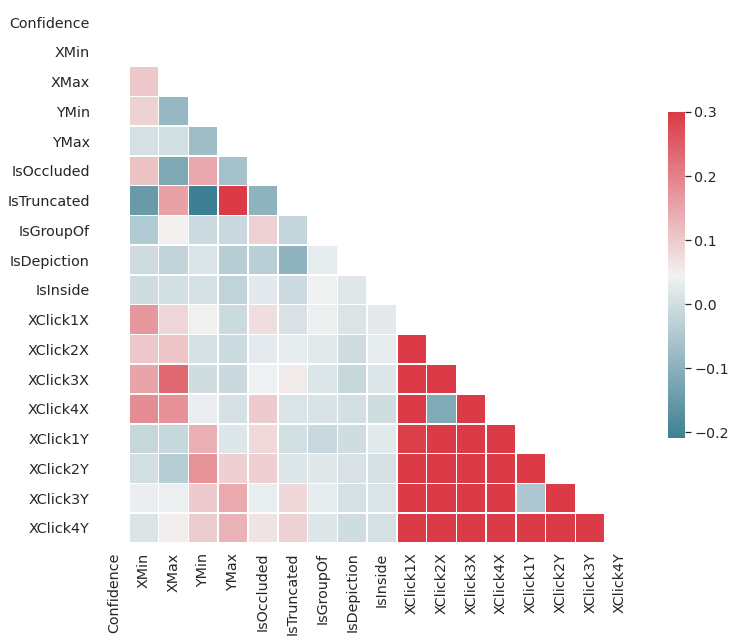

In [34]:
# data correlation LLM
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3)

class_labels = ["cat", "dog"]

# compute the correlation matrix
corr = df.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

# Preprocess

## Rescale the images - 128x128

This rescaling will resize (and deform) all images to the same dimensions, 128 wide by 128 high.  The bounding box information in the CSV file are based on percentages and not pixel locations, so bounding box info is already normalized.  The rescaling of images to 128x128 in effect normalizes the image data so that we can better compare bounding boxes and images on the same dimensions without having to do further transformations.

In [35]:
%%time

!mkdir -p images/resized128


# resize image and save, convert to numpy
def saveImageAndResize(w,h,ch):
    # w = 128, h = 128, ch = 3
    arr = np.zeros((df.shape[0],w*h*ch))
    
    for i, f in enumerate(tqdm(df.ImageID)):
        img = Image.open(path+f+'.jpg')
        img_resized = img.resize((w,h))
        img_resized.save("images/resized"+str(w)+"/"+f+'.jpg', "JPEG", optimize=True)
        arr[i] = np.asarray(img_resized, dtype=np.uint8).flatten()
        img.close() # cleanup!
    return arr

img_arr = saveImageAndResize(128,128,3)


  0%|          | 0/12966 [00:00<?, ?it/s]

CPU times: user 1min 13s, sys: 9.53 s, total: 1min 23s
Wall time: 5min 9s


Plot the resized and filtered images

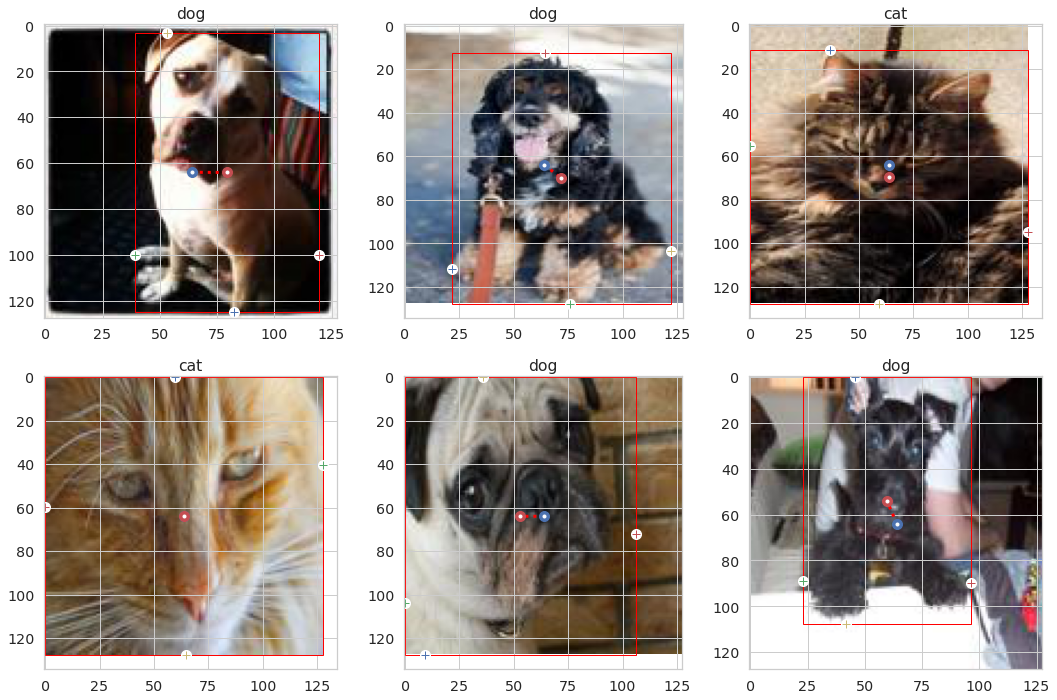

In [36]:
# plot random 6 of the 128x128 images
RandomSixImages(df, False, 128)

## Encode Labels

In [37]:
# encode labels
df['Label'] = (df.LabelName == 'dog').astype(np.uint8)

## Resize images (32x32)

In [38]:
%%time

!mkdir -p images/resized32

img_arr32 = saveImageAndResize(32,32,3)

  0%|          | 0/12966 [00:00<?, ?it/s]

CPU times: user 53.9 s, sys: 5.29 s, total: 59.2 s
Wall time: 3min 50s


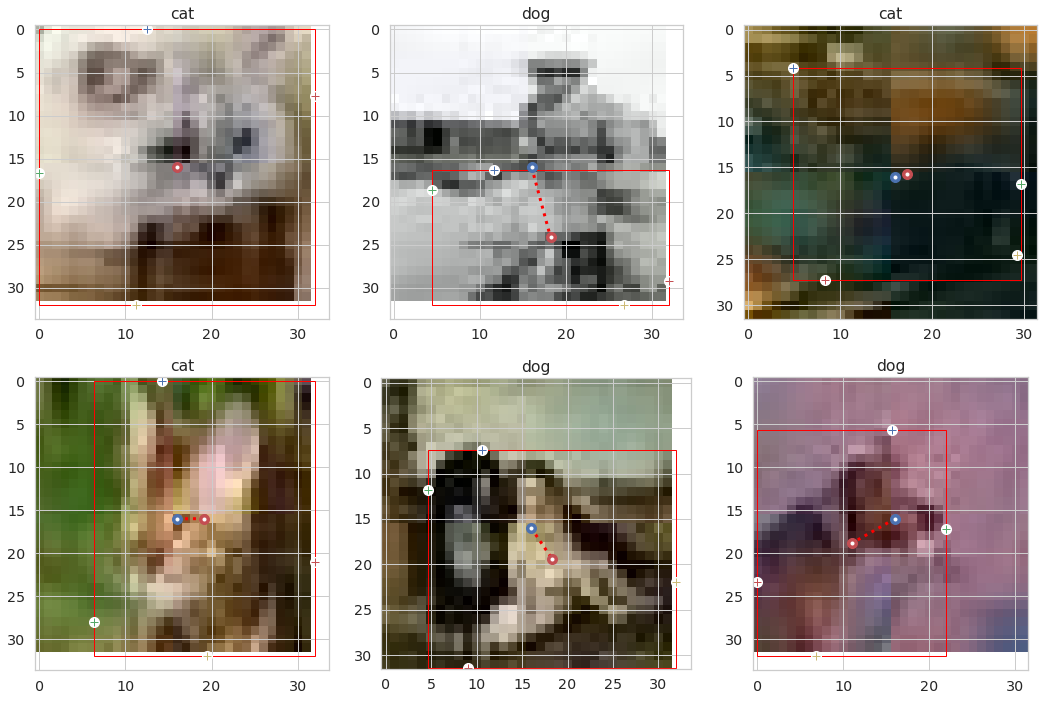

In [39]:
# plot random 6 of the 32x32 images
RandomSixImages(df, False, 32)

# Split Data 

## Checkpoint and Save data

In [43]:
!mkdir -p data

# Skip/comment out the following steps if you've already exported the data as it takes a while.
np.save(path + '../img128.npy', img_arr.astype(np.uint8), allow_pickle=True)
np.save(path + '../img32.npy', img_arr32.astype(np.uint8), allow_pickle=True)
np.save(path + '../y_label.npy', df.Label.values, allow_pickle=True)
np.save(path + '../y_bbox.npy', df[['XMin', 'YMin', 'XMax', 'YMax']].values.astype(np.float32), allow_pickle=True)

## Load data

In [7]:
X128 = np.load(path + '../img128.npy', allow_pickle=True)
X32 = np.load(path + '../img32.npy', allow_pickle=True)
y_label = np.load(path + '../y_label.npy', allow_pickle=True)
y_bbox = np.load(path + '../y_bbox.npy', allow_pickle=True)

## Train and Test Split

### Numpy to Tensor & Normalize

In [8]:
X = torch.FloatTensor(X32)
y_label = torch.FloatTensor(y_label)
y_bbox = torch.FloatTensor(y_bbox)

X_train, X_test, y_train_label, y_test_label, y_train_box, y_test_box  = train_test_split(X, y_label,y_bbox, test_size=0.01, random_state=27) 

In [9]:
# Normalize
X_train.shape

torch.Size([12836, 3072])

In [24]:


X_train = X_train / 255
X_test = X_test / 255
y_train_label = y_train_label / 255
y_test_label = y_test_label / 255
y_train_box = y_train_box / 255
y_test_box = y_test_box / 255

# Need to reshape from flat (what was stored in numpy) out to 3 channels by 32 by 32.
X_train = X_train.reshape(-1,3,32,32)
X_test = X_test.reshape(-1,3,32,32)

X_train.shape[0]

12836

# PyTorch Implementation

In [11]:


# Configure device for gpu or cpu depending on what's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/usr/local/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


## Create the Model class

In [13]:
class ConvNet(nn.Module):
    # Conv2d, pool, Conv2d, pool layering scheme adapted from Group 4's Phase 2 notebook share.

    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3),stride=(1,1),padding=(1,1)) 
        
        # Reduce dimensions by half - POOL
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)) 
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3),stride=(1,1),padding=(1,1)) 
        
        # Reduce dimensions by half again - POOL
        self.fc_label = nn.Linear(16 * 8 * 8, 120) 
        self.out_label = nn.Linear( in_features=120, out_features=2)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # first layer
        x = self.pool1(x) # pool
        x = F.relu(self.conv2(x)) # second layer
        x = self.pool1(x) # pool
        x = x.reshape(x.shape[0],-1)

        # Classify
        x1 = F.relu(self.fc_label(x)) 
        # Classify output
        x1 = F.log_softmax(self.out_label(x1), dim=1) 
        return x1


    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


conv_net = ConvNet()
print(conv_net)



ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc_label): Linear(in_features=1024, out_features=120, bias=True)
  (out_label): Linear(in_features=120, out_features=2, bias=True)
)


## Train the model

In [51]:
def convTrain(model,maxepoch = 10,eta = 0.01):
    loss_train = []
    loss_test = []
    acc_train = []
    acc_test = []
    stepnums = []
    steps = 0
    crit1 = nn.CrossEntropyLoss()
    params = model.parameters()
    optimiz = Adam(params, lr=eta, weight_decay=0)
    traintotal = X_train.shape[0]
    
    for epoch in range(maxepoch):
        y_pred = model(X_train)
        _, pred_labels = torch.max(y_pred.data, 1)  
        correct = (pred_labels == y_train_label).sum().item()
        train_loss = crit1(y_pred, y_train_label.type(torch.LongTensor))
        loss_train.append(train_loss)      

        y_pred_test = model(X_test)
        test_loss = crit1(y_pred_test, y_test_label.type(torch.LongTensor))
        loss_test.append(test_loss)      
        print('epoch: ', epoch+1,' loss: ', train_loss.item())
        optimiz.zero_grad()
        train_loss.backward()
        optimiz.step()
    
        acc_test.append( 100 * correct / traintotal)
        stepnums.append(steps)
        steps+=1
    
    return {"epoch": stepnums, "train_loss": loss_train, "test_loss": loss_test, "train_accuracy": acc_train, "test_accuracy": acc_test }
        

In [52]:
results = []

In [53]:
results.append(convTrain(conv_net))

epoch:  1  loss:  0.7229611277580261
epoch:  2  loss:  0.005692302715033293
epoch:  3  loss:  7.27551878298982e-07
epoch:  4  loss:  3.529097292176431e-10
epoch:  5  loss:  0.0
epoch:  6  loss:  0.0
epoch:  7  loss:  0.0
epoch:  8  loss:  0.0
epoch:  9  loss:  0.0
epoch:  10  loss:  0.0


In [ ]:
print(results)

## Add CXE + MSE and adjust Model for bounding boxes

In [33]:
class ConvNetLabelBbox(nn.Module):
    # Conv2d, pool, Conv2d, pool layering scheme adapted from Group 4's Phase 2 notebook share.
    # For some reason, can't get as good of accuracy

    def __init__(self):
        super(ConvNetLabelBbox, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3),stride=(1,1),padding=(1,1)) 
        
        # Reduce dimensions by half - POOL
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)) 
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3),stride=(1,1),padding=(1,1)) 
        
        # Reduce dimensions by half again - POOL
        self.fc_label = nn.Linear( 16 * 8 * 8, 120) 
        self.out_label = nn.Linear( in_features=120, out_features=2)
        
        self.fc_bbox = nn.Linear( in_features=16 * 8 * 8,  out_features=120)
        self.out_bbox = nn.Linear( in_features=120, out_features=4) # One out feature for each BBOX coordinate

    def forward(self, x):
        x = F.relu(self.conv1(x)) # first layer
        x = self.pool1(x) # pool
        x = F.relu(self.conv2(x)) # second layer
        x = self.pool1(x) # pool
        x = x.reshape(x.shape[0],-1)

        # All data goes through the layers, then we split for the final predictions.
        
        xlabel = F.relu(self.fc_label(x)) # cat/dog?
        xlabel = F.log_softmax(self.out_label(xlabel), dim=1) # prediction output for label

        xbbox = F.relu(self.fc_bbox(x)) # regression
        xbbox = self.out_bbox(xbbox) # regression output Layer
        return xlabel, xbbox

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


conv_netLB = ConvNetLabelBbox()
print(conv_netLB)

ConvNetLabelBbox(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc_label): Linear(in_features=1024, out_features=120, bias=True)
  (out_label): Linear(in_features=120, out_features=2, bias=True)
  (fc_bbox): Linear(in_features=1024, out_features=120, bias=True)
  (out_bbox): Linear(in_features=120, out_features=4, bias=True)
)


In [34]:
def convLBTrain(model,maxepoch = 7,eta = 0.001):
    
    train_data = torch.utils.data.TensorDataset(X_train, y_train_label, y_train_box)
    test_data = torch.utils.data.TensorDataset(X_test, y_test_label, y_test_box)
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
    
    loss_train = []
    loss_MSE_train = []
    loss_CXE_train = []
    loss_total = []
    
    loss_test = []
    acc_train = []
    acc_test = []
    acc_total = []
    stepnums = []
    steps = 0
    
    crit1 = nn.CrossEntropyLoss(reduction='mean') # add mean reduction
    crit2 = nn.MSELoss() # add mse loss

    params = model.parameters()
    optimiz = Adam(params, lr=eta, weight_decay=0)

    acc_train = [0] * maxepoch
    acc_test = [0] * maxepoch
    loss_train = [0] * maxepoch
    loss_test = [0] * maxepoch
    
    for epoch in tqdm(range(maxepoch)):
    
        correct = 0
        total = 0
        running_loss =0
        correct_val=0
        total_val = 0
        running_loss_val = 0


        for batch, data in enumerate(train_dataloader):
            inputs, predlabels, predbox = data[0].to(device), data[1].to(device), data[2].to(device)
            optimiz.zero_grad()
            
            outputs1, outputs2 = model(inputs) #forward pass
            _,predicted = torch.max(outputs1.data, 1)
            predicted.to(device)
            total += predlabels.size(0)
            correct += (predicted == predlabels).sum().item()
            acc_total.append( 100 * correct / total )
    
            loss1 = crit1(outputs1, predlabels.type(torch.LongTensor)) 
            loss2 = crit2(outputs2.data, predbox.float())
            loss_CXE_train.append(loss1)
            loss_MSE_train.append(loss2)


            loss_train = loss1 + loss2 #combined loss
            #print('CXE Loss',loss1.item(),'MSE Loss',loss2.item(),'Total Loss:',loss_train.item())
            loss_total.append(loss_train)
            loss_train.backward() #backward pass
            optimiz.step()
            running_loss += loss_train.item()
            steps +=1
            stepnums.append(steps)
            
        print('End of Epoch ' + str(epoch + 1) + ", Running loss " + str(running_loss))
    return stepnums, loss_MSE_train, loss_CXE_train, loss_total, acc_total

steps, MSEloss, CXEloss, totalLoss, totalAcc = convLBTrain(conv_netLB)

  0%|          | 0/7 [00:00<?, ?it/s]

End of Epoch 1, Running loss 6.492093376815319
End of Epoch 2, Running loss 0.13909522537142038
End of Epoch 3, Running loss 0.13773517578374594
End of Epoch 4, Running loss 0.1361821835162118
End of Epoch 5, Running loss 0.13613411888945848
End of Epoch 6, Running loss 0.13612487993668765
End of Epoch 7, Running loss 0.13612047373317182


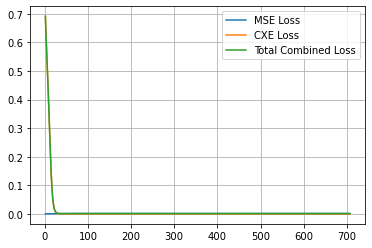

In [35]:
plt.plot(steps, MSEloss, label='MSE Loss')
plt.plot(steps, CXEloss, label='CXE Loss')
plt.plot(steps, totalLoss, label='Total Combined Loss')
plt.legend()
plt.grid()
plt.show()

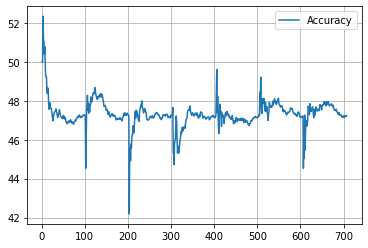

In [36]:
plt.plot(steps, totalAcc, label='Accuracy')
plt.legend()
plt.grid()
plt.show()

## Ben's - only look at training on class cat/dog - Create train_csv.csv

In [ ]:
def label_img(row):
    if row['LabelName'] == '/m/0bt9lr':
        return 1
    if row['LabelName'] == '/m/01yrx':
        return 0


In [ ]:
df2 = df
df2.head()

In [ ]:
df2['cdlabel'] = df2.apply(lambda row: label_img(row), axis=1)
df2['cdlabel'].unique()

In [ ]:
df3 = pd.concat([df2['ImageID'], df2['cdlabel']], axis=1, keys=['ImageID', 'label'])

In [ ]:
df3.head()

In [ ]:
df3.to_csv(r'train_csv.csv', index=False, header=True)

## Create (New) Custom Dataset

In [ ]:
class CustomDataload(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id+'.jpg')).convert("RGB")
        y_label = torch.tensor(self.annotations.iloc[index, 1])
       
        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)


In [ ]:
#Set training set transform process on PIL Image item from custom dataset 
train_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Set test set transformations:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])


train_file = 'train_csv.csv'
img_dir = '/content/drive/MyDrive/Colab Notebooks/CatsNDogs/data/cadod/'

all_data = CustomDataload(root_dir=img_dir, annotation_file=train_file, transform=train_transform)

In [ ]:
batch_size = 64
# shuffle = True
# test_split = .2
 
# dataset_size = len(all_data)
# indices = list(range(dataset_size))
 
# split = int(np.floor(test_split * dataset_size))
# np.random.seed(27)
# np.random.shuffle(indices)
 
# train_indices, test_indices = indices[split:], indices[:split]
 
# #call the subset sampler to sample our data
# train_sampler = SubsetRandomSampler(train_indices) #random sample for the indices for training data and test data
# test_sampler = SubsetRandomSampler(test_indices)

num_train = int(len(all_data) * 0.8)
train_set, test_set = torch.utils.data.random_split(all_data, [num_train, len(all_data) - num_train])

# Make Train Loader:
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
                                  
# Make test loader:
test_dataloader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

## Define the Model

In [ ]:
class Unit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unit, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, kernel_size=3, 
                              out_channels=out_channels, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

class ImgNet(nn.Module):
    def __init__(self, num_classes):
        super(ImgNet, self).__init__()

         #Create 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3,out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=32)
        self.unit3 = Unit(in_channels=32, out_channels=32)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.unit13 = Unit(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, 
                                 self.unit4, self.unit5, self.unit6 
                                 ,self.unit7, self.pool2, self.unit8, 
                                 self.unit9, self.unit10, self.unit11, self.pool3,
                                 self.unit12, self.unit13, self.unit14, self.avgpool)
        
        self.fc = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128)
        output = self.fc(output)
        return output


## Train Model

In [ ]:
from torch.optim import Adam

cuda_avail = torch.cuda.is_available()

model = ImgNet(num_classes=2)

if cuda_avail:
    model.cuda()

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
for name, param in model.named_parameters():
  print(name, '\t', param.shape)

In [ ]:
# Check for available GPU for modelNN:
if torch.cuda.is_available():
    model.cuda()

**Maybe a learning rate adjuster??**

In [ ]:
# https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864

# # Create a learning rate adjustment function that divides the learning rate by 10 every 30 epochs
# def adjust_learning_rate(epoch):
#     lr = 0.001

#     if epoch > 180:
#         lr = lr / 1000000
#     elif epoch > 150:
#         lr = lr / 100000
#     elif epoch > 120:
#         lr = lr / 10000
#     elif epoch > 90:
#         lr = lr / 1000
#     elif epoch > 60:
#         lr = lr / 100
#     elif epoch > 30:
#         lr = lr / 10

#     for param_group in optimizer.param_groups:
#         param_group["lr"] = lr


### Test Function

In [ ]:
def save_models(epoch):
    torch.save(model.state_dict(), "cadodModel_{}.model".format(epoch))
    print("Checkpoint saved")

In [ ]:
def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_dataloader):

        if cuda_avail:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)

        test_acc += torch.sum(prediction == labels.data)

    test_acc = test_acc / 2593

    return test_acc

## Train Function

In [ ]:
# https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864

def train(num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_dataloader):
            # Move images and labels to gpu if available
            if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            # Clear all accumulated gradients
            optimizer.zero_grad()
            # Predict classes using images from the test set
            outputs = model(images)
            # Compute the loss based on the predictions and actual labels
            loss = loss_fn(outputs, labels)
            # Backpropagate the loss
            loss.backward()

            # Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss += loss.cpu().data * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            
            train_acc += torch.sum(prediction == labels.data)

        # Call the learning rate adjustment function
        # adjust_learning_rate(epoch)

        # Compute the average acc and loss over all 50000 training images
        train_acc = train_acc / num_train
        train_loss = train_loss / num_train

        # Evaluate on the test set
        test_acc = test()

        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
            save_models(epoch)
            best_acc = test_acc

        # Print the metrics
        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch,
                                                                                        train_acc,
                                                                                        train_loss,
                                                                                        test_acc))
                        

## Run Tests

In [ ]:
if __name__ == '__main__':
    train(35)



In [ ]:
train(modelnet, train_dataloader, test_dataloader, 10, log_dir1=None, log_dir2=None)

In [ ]:
if __name__ == "__main__":
    train(train_dataloader, test_dataloader, 20)